<a href="https://colab.research.google.com/github/DNedilko/ProbabilisticMachineLearning/blob/main/Project/GP/GP_1%262.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQPZE9O4_sVQLK9CqFslYaAF9nnRAN0vL-qAoTwsvb_jvA7-sx54FzXAJfYvr_eXcWwbTMkFh4I91KM/pub?gid=2066991495&single=true&output=csv'
df= pd.read_csv(url)
print(df.head())

### Task 2

We now apply GPs to monthly CO\textsubscript{2} measurements at Mauna Loa, Hawaii. The dataset is loaded from \texttt{co2\_mm\_mlo.csv}. Following the template, the first 120 observations (1958--1968) are used for training and the next 60 (1968--1973) for prediction:
\begin{align*}
X_{\text{train}} &= \{t_i - 1958\}_{i=1}^{120},
&
y_{\text{train}} &= \text{CO2 ppm at } t_i,
\\
X_{\text{test}} &= \{t_j - 1958\}_{j=121}^{180},
&
y_{\text{test}} &= \text{CO2 ppm at } t_j.
\end{align*}
The targets are normalised for numerical stability:
\[
y = \frac{y_{\text{train}} - \mu_y}{\sigma_y}.
\]


In [ ]:
import pandas as pd

csv_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQOXYRQ_s-va_gJ7grboyxqLJefIbpRiSo6kLjvS3Bh3ZVHXuMuSeLVtTbNZtfjr4Z3LPnU8rMSItyc/pub?gid=572768798&single=true&output=csv'
names = ["year","month","decimal_date","average","deseasonalized","ndays","sdev","unc"]
df = pd.read_csv(csv_url, header=None, names=names)

display(df.head())

,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


#### From templates

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import scipy.optimize as opt

In [ ]:
def gaussian_kernel(X,Xprime, gamma=10):
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return np.exp(-gamma*dists)

In [ ]:
def special_kernel(X,Xprime, eta):
    a = eta[0]
    b = eta[1]
    K = (1+X@Xprime.T)**2 + a * \
        np.multiply.outer(np.sin(2*np.pi*X.reshape(-1)+b),np.sin(2*np.pi*Xprime.reshape(-1)+b))
    return K

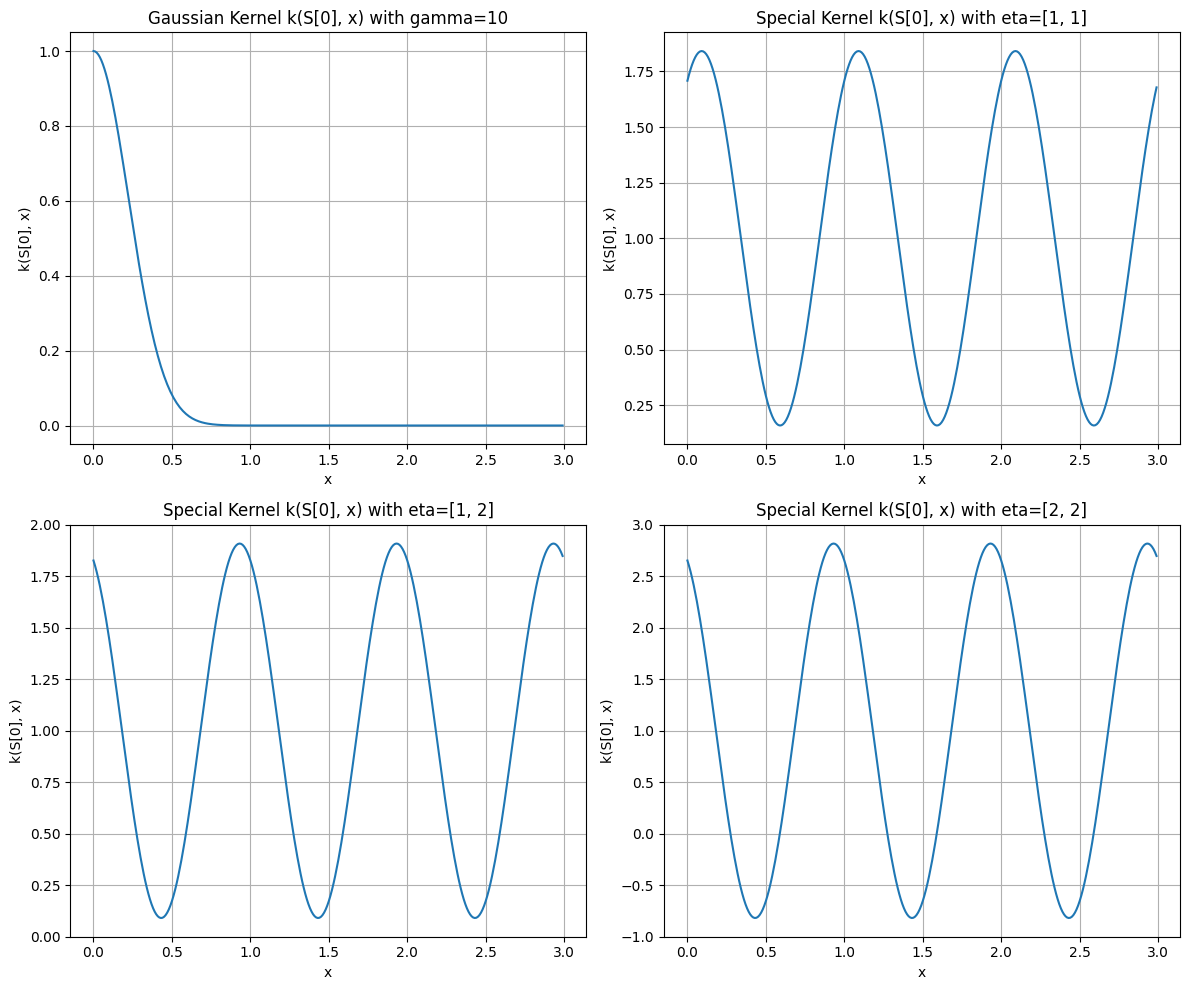

In [ ]:
S = np.arange(0, 3, 0.01)
S = S.reshape(-1, 1)

# Gaussian Kernel
gamma_gaussian = 10
K_gaussian_plot = gaussian_kernel(S[0].reshape(1, -1), S, gamma=gamma_gaussian).flatten()

# Special Kernel
eta_special = [[1,1], [1,2], [2,2]]
K_special_plot1 = special_kernel(S[0].reshape(1, -1), S, eta=eta_special[0]).flatten()
K_special_plot2 = special_kernel(S[0].reshape(1, -1), S, eta=eta_special[1]).flatten()
K_special_plot3 = special_kernel(S[0].reshape(1, -1), S, eta=eta_special[2]).flatten()



plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(S, K_gaussian_plot)
plt.title(f"Gaussian Kernel k(S[0], x) with gamma={gamma_gaussian}")
plt.xlabel("x")
plt.ylabel("k(S[0], x)")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(S, K_special_plot1)
plt.title(f"Special Kernel k(S[0], x) with eta={eta_special[0]}")
plt.xlabel("x")
plt.ylabel("k(S[0], x)")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(S, K_special_plot2)
plt.title(f"Special Kernel k(S[0], x) with eta={eta_special[1]}")
plt.xlabel("x")
plt.ylabel("k(S[0], x)")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(S, K_special_plot3)
plt.title(f"Special Kernel k(S[0], x) with eta={eta_special[2]}")
plt.xlabel("x")
plt.ylabel("k(S[0], x)")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
df.head()

,year,month,decimal_date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99


In [ ]:
#load and normalize Mauna Loa data
data = df.to_numpy()
#10 years of data for learning
X = data[:120,2]-1958
y_raw = data[:120,3]
y_mean = np.mean(y_raw)
y_std = np.sqrt(np.var(y_raw))
y = (y_raw-y_mean)/y_std
#the next 5 years for prediction
X_predict = data[120:180,2]-1958
y_predict = data[120:180,3]
X = X.reshape(-1, 1)
X_predict = X_predict.reshape(-1, 1)


In [ ]:
print(data.shape, X.shape, X_predict.shape)


(776, 8) (120, 1) (60, 1)


Given a kernel $k(\cdot,\cdot)$ with hyperparameters $\eta$ and observation noise variance $\sigma_n^2$, the standard GP regression model assumes
$$
y_i = f(x_i) + \varepsilon_i, \qquad \varepsilon_i \sim \mathcal{N}(0,\sigma_y^2I_n),
$$
with prior $f \sim \mathcal{GP}(0,k)$.

For $S = (X,X*)$ let $K_{\eta}(S) = k_{\eta}(S, S)$ be the $n\times n$ training kernel matrix, $k_{\eta}(X,X^*)$ the $n\times n^*$ cross-kernel between training and test inputs, and $k(X^*,X^*)$ the $n^*\times n^*$ test kernel matrix. The distribution of noisy opservations $y$ is
\begin{equation}
p(y \mid X, \eta, \sigma_y^2)
= \mathcal{N}\bigl(y; 0, K_\eta(S) + \sigma_n^2 I\bigr).
\end{equation}
The corresponding negative log likelihood is implemented as
$$
\text{NLL}(\sigma_n^2, \eta) = -log \;p(y \mid X, \eta, \sigma_y^2)
= \tfrac{1}{2} y^\top K_y^{-1} y
+ \tfrac{1}{2} \log \det K_y
+ \tfrac{n}{2} \log(2\pi),
$$
with $K_y(S) = K_\eta(S) + \sigma_y^2I_m I$.

For prediction at $X^*$, the GP posterior over $f^* = f(X^*); f|y \sim \mathcal{N}(\mu^*, Σ^*)$ is
\begin{align}
\mu_* &= k_\eta(X, X^*) K_y(X)^{-1} y, \\
\Sigma_* &= k(X^*,X^*) - k(X^*,X) K_y(X)^{-1} K(X,X^*).
\end{align}


In [ ]:
# B) todo: implement this
def negLogLikelihood(params, kernel):
    noise_var = params[0]
    eta = params[1:]

    K = kernel(X, X, eta) if kernel == special_kernel else kernel(X, X, eta[0])
    K += noise_var * np.eye(len(X))

    L = scipy.linalg.cholesky(K, lower=True)
    alpha = scipy.linalg.cho_solve((L, True), y)

    nll = 0.5 * y.T @ alpha
    nll += np.sum(np.log(np.diag(L)))
    nll += 0.5 * len(X) * np.log(2 * np.pi)

    return nll


In [ ]:
def optimize_params(ranges, kernel, Ngrid):
    opt_params = opt.brute(lambda params: negLogLikelihood(params, kernel), ranges,
    Ns=Ngrid, finish=None)
    noise_var = opt_params[0]
    eta = opt_params[1:]
    return noise_var, eta

In [ ]:
k_et = lambda X, Xprime, eta: special_kernel(X, Xprime, eta)

# B) todo: implement the posterior distribution, i.e. the distribution of f^star
def conditional(X, y, noise_var, eta, kernel):
    K = kernel(X, X, eta) if kernel == special_kernel else kernel(X, X, eta[0])
    K += noise_var * np.eye(len(X))

    Ks = kernel(X, X_predict, eta) if kernel == special_kernel else kernel(X, X_predict, eta[0])
    Kss = kernel(X_predict, X_predict, eta) if kernel == special_kernel else kernel(X_predict, X_predict, eta[0])

    L = scipy.linalg.cholesky(K, lower=True)
    alpha = scipy.linalg.cho_solve((L, True), y)

    mustar = Ks.T @ alpha
    v = scipy.linalg.solve_triangular(L, Ks, lower=True)
    Sigmastar = Kss - v.T @ v

    return mustar, Sigmastar

In [ ]:
# B) todo: use the learned GP to predict on the observations at X_predict
kernel = gaussian_kernel # todo: change to new kernel
ranges = ((1.e-4,10), (10,10)) # todo: change to the new parameters
Ngrid = 10
noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)


prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel)
var_gp = np.diag(Sigma_gp)

optimal params: 1.1112 [10.]


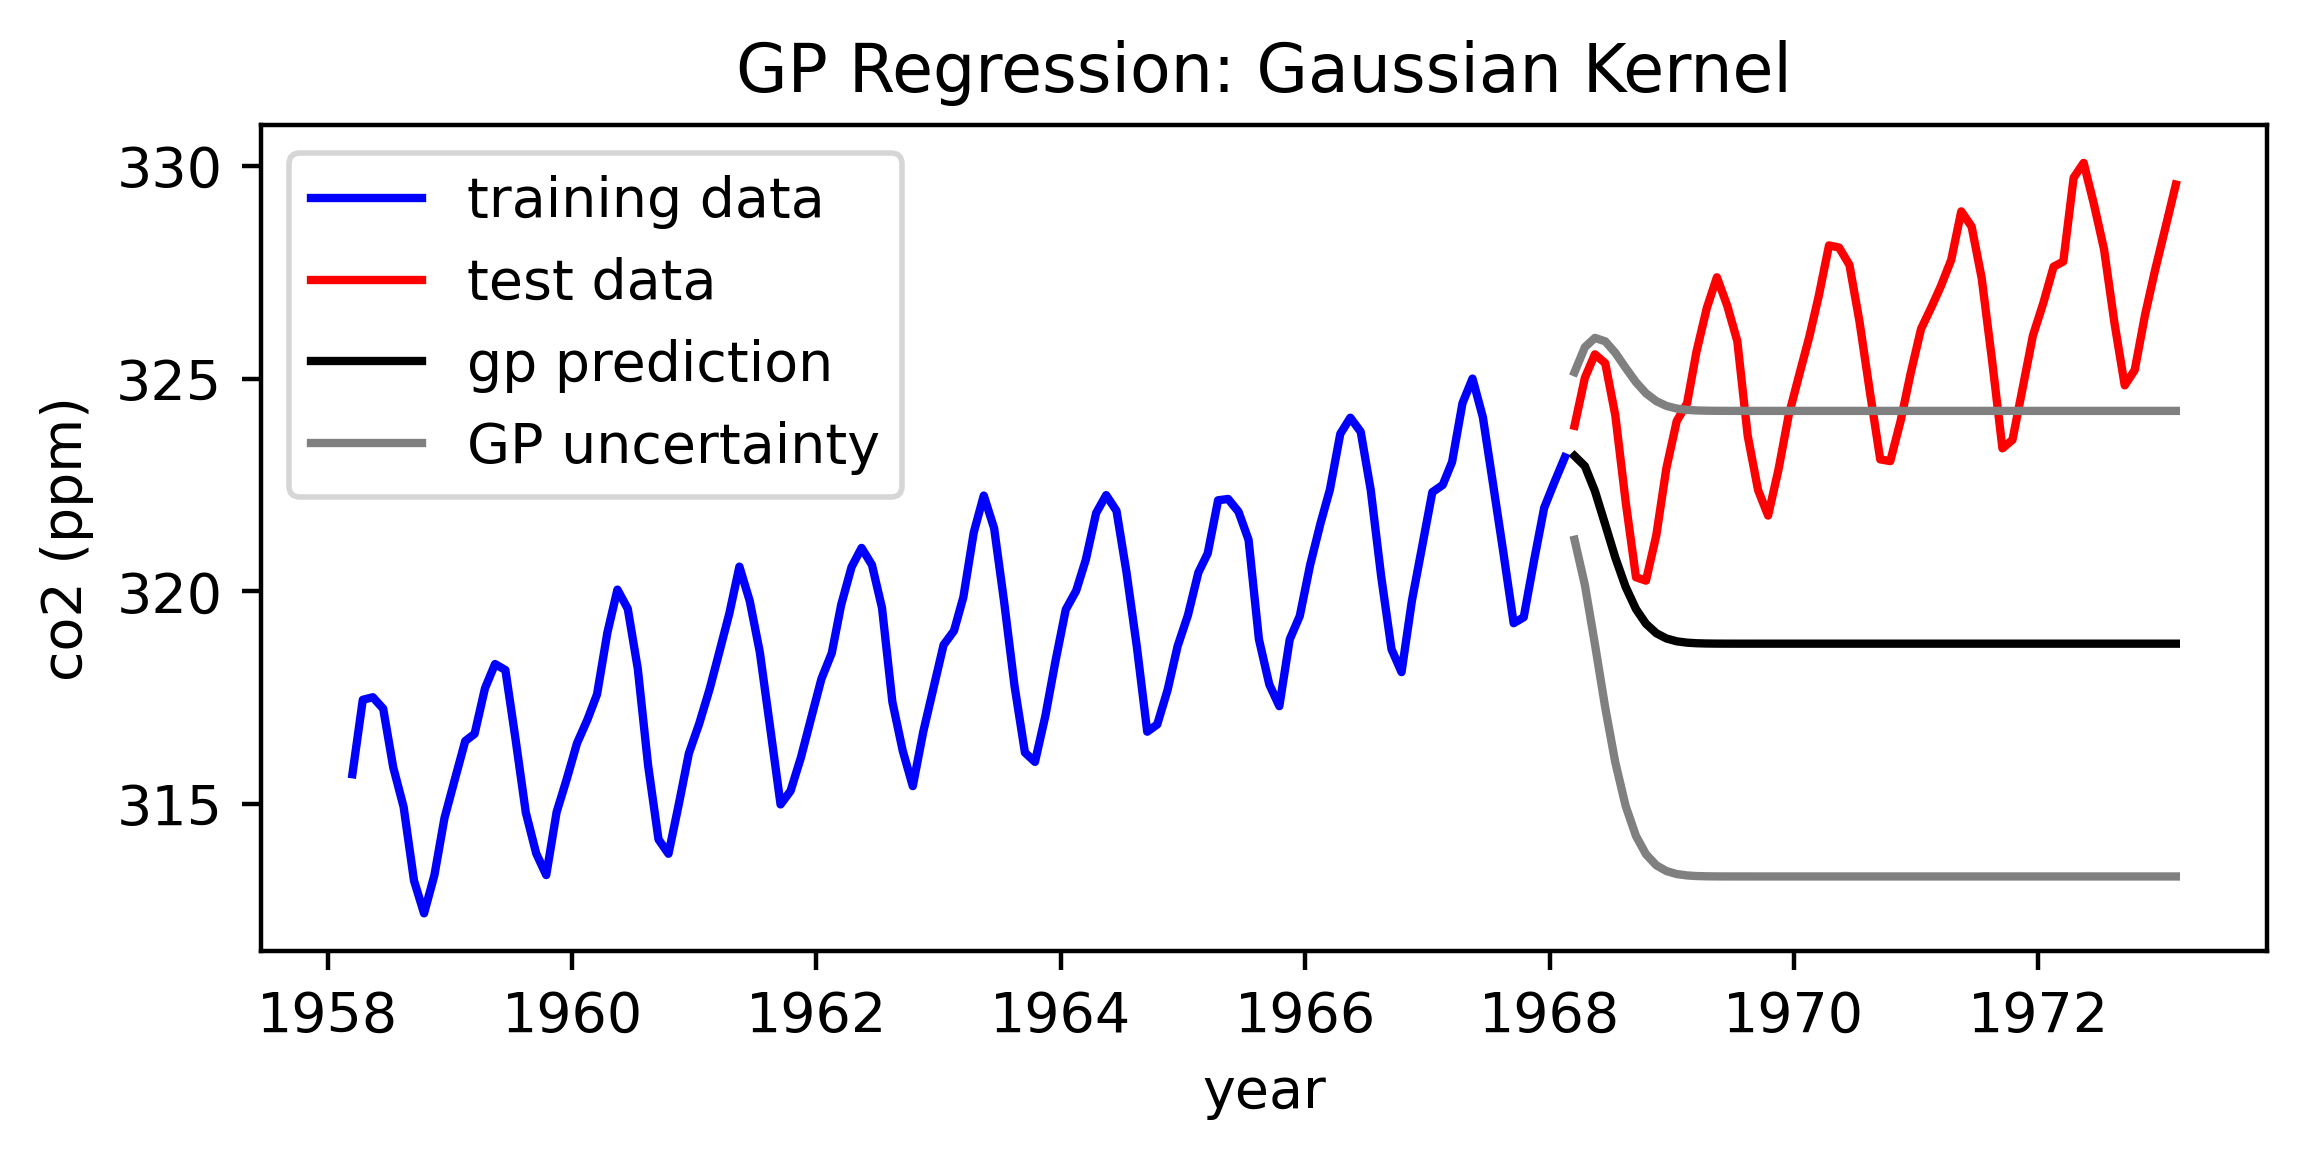

In [ ]:
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')

yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2

plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, yout_m + 1.96 * np.sqrt(yout_v), color='grey', label='GP uncertainty')
plt.plot(X_predict + 1958, yout_m - 1.96 * np.sqrt(yout_v), color='grey')

plt.title("GP Regression: Gaussian Kernel")
plt.xlabel("year")
plt.ylabel("co2 (ppm)")
plt.legend()
plt.tight_layout()
plt.show()

## week 2


### Programming Exercise, GPs pt. 2

In [ ]:
# C) todo: adapt this
kernel = special_kernel
ranges = ((1e-4, 1.0), (1e-4, 10.0), (0.0, 2*np.pi))  # noise_var, a, b
Ngrid = 8

noise_var, eta = optimize_params(ranges, kernel, Ngrid)
print("optimal params:", noise_var, eta)

# Prediction
prediction_mean_gp, Sigma_gp = conditional(X, y, noise_var, eta, kernel)
var_gp = np.diag(Sigma_gp)

optimal params: 0.14294285714285712 [1.42865714 2.6927937 ]


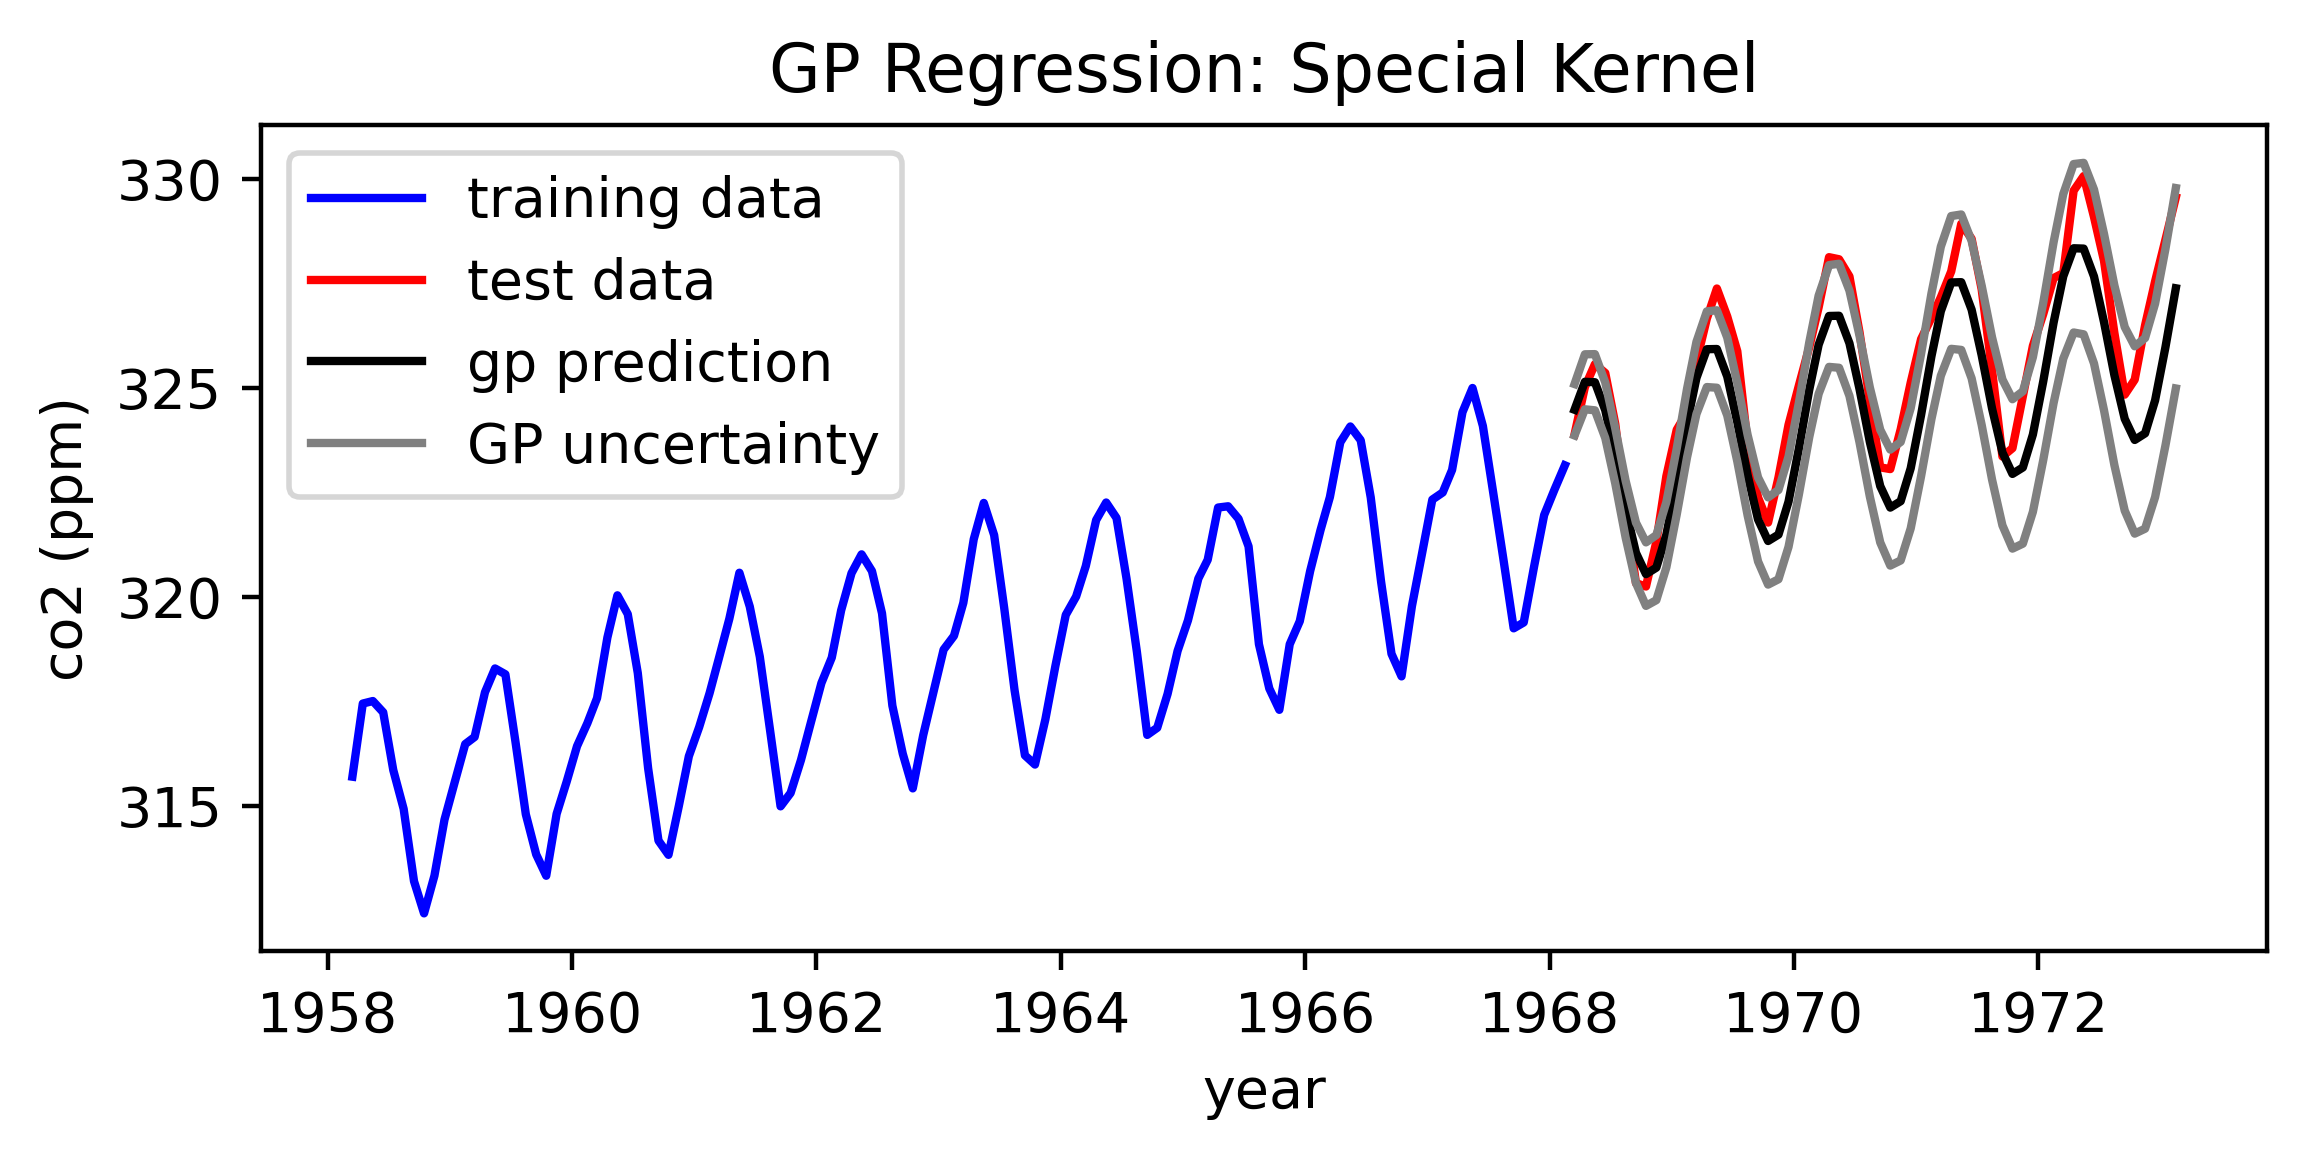

In [ ]:
plt.figure(dpi=400, figsize=(6, 3))
plt.plot(X + 1958, y_raw, color='blue', label='training data')
plt.plot(X_predict + 1958, y_predict, color='red', label='test data')

yout_m = prediction_mean_gp * y_std + y_mean
yout_v = var_gp * y_std**2

plt.plot(X_predict + 1958, yout_m, color='black', label='gp prediction')
plt.plot(X_predict + 1958, yout_m + 1.96 * np.sqrt(yout_v), color='grey', label='GP uncertainty')
plt.plot(X_predict + 1958, yout_m - 1.96 * np.sqrt(yout_v), color='grey')

plt.title("GP Regression: Special Kernel")
plt.xlabel("year")
plt.ylabel("co2 (ppm)")
plt.legend()
plt.tight_layout()
plt.show()